In [65]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.ticker
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
provider = OriginDestinationEmploymentDataProvider()
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
import seaborn as sns
from shapely.geometry import Point

import statistics
import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [9]:
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]

In [3]:
def build_training_set(network, target_column):
    # explode the dataset to include all node pairs
    node_ids = network.nodes.index.values
    origins = pd.DataFrame(node_ids, columns = ['origin'])
    destinations = pd.DataFrame(node_ids, columns = ['destination'])
    cartesian_product = origins.merge(destinations, how='cross')
    
    # compute distnace between all pairs
    centroid = network.nodes.centroid
    centroid_long = centroid.x
    centroid_long.name = 'long'
    centroid_lat = centroid.y
    centroid_lat.name = 'lat'
    centroids = pd.concat([centroid_long, centroid_lat], axis=1)
    centroid_from = cartesian_product.join(centroids, on=network._origin).rename(columns={'long': 'long_from', 'lat': 'lat_from'})
    centroid_all = centroid_from.join(centroids, on=network._destination).rename(columns={'long': 'long_to', 'lat': 'lat_to'})
    from_points = list(zip(centroid_all.lat_from, centroid_all.long_from))
    to_points = list(zip(centroid_all.lat_to, centroid_all.long_to))
    centroid_all['distance'] = haversine_vector(from_points, to_points, Unit.KILOMETERS)
    centroid_all.drop(['long_from', 'lat_from', 'long_to', 'lat_to'], axis=1, inplace=True)
#     print(centroid_all.columns)
    centroid_above = centroid_all.loc[centroid_all.distance > 0]
    centroid_below = centroid_all.loc[centroid_all.distance == 0]
    del centroid_below['distance']
    misDistance = centroid_above.groupby(['origin']).agg({'distance':min})
    misDistance['distance'] = misDistance['distance']
    centroid_below = centroid_below.merge(misDistance,on=['origin'])
#     centroid_all.loc[centroid_all.distance == 0, 'distance'] = centroid_all.loc[centroid_all.distance > 0, 'distance'].min()*0.5
    centroid_all = pd.concat([centroid_above,centroid_below],axis=0)
    # compute jobs and residence
    comp_aggs={target_column: 'sum'}
    jobs = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={target_column: 'jobs'})
    residence = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={target_column: 'residence'})
    features = centroid_all.join(residence, on='origin').join(jobs, on='destination')
    
    # merge flow data
    flow = network.edges.rename(columns={target_column: 'flow'})[['origin', 'destination', 'flow']]
    combined = features.merge(flow, how='left', on=['origin', 'destination']).fillna(0)
    
    return combined

In [6]:
# change here to age groups
target_columns = ['S000','SE01','SE03']
for city, state, conties in cities:
    
    print(city)
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    for target_column in target_columns:
        training_set = build_training_set(city_network, target_column)
        training_set.to_parquet(f'data/{target_column}_{city}.parquet',index=False)

New York City
Los Angeles
Chicago
Houston
Boston
Phoenix
Philadelphia
San Antonio
San Diego
Dallas
San Jose
Austin


In [7]:
for city, state, conties in cities:
    df0 = pd.read_parquet(f'data/S000_{city}.parquet')
    df1 = pd.read_parquet(f'data/SE01_{city}.parquet')
    df3 = pd.read_parquet(f'data/SE03_{city}.parquet')
    df0.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
    df1.rename(columns={'jobs':'SE01jobs', 'residence':'SE01residence','flow':'SE01flow'}, inplace=True)
    df3.rename(columns={'jobs':'SE03jobs', 'residence':'SE03residence','flow':'SE03flow'}, inplace=True)
    merged = df0.merge(df1,on=['origin','destination'],how='outer').merge(df3,on=['origin','destination'],how='outer')
    merged.to_parquet(f'data/income_{city}.parquet', index=False)

# baseline

### unconstrain model, power law

In [13]:
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def baseline_fit(df,target):
    X = ['distance',target+'jobs',target+'residence']
    y = target+'flow'
    pars, cov = optimize.curve_fit(f=power_law, xdata=df[X].values, ydata=df[y].values, bounds=(-np.inf, np.inf))
    return pars
def baseline_predict(test,target,pars):
    test[target+'k'] = pars[0]
    test[target+'a'] = pars[1]
    test[target+'pred'] = test[target+'k']*(test['distance']**test[target+'a'])*test[target+'jobs']*test[target+'residence']
    return test

## f(d)

In [14]:
def unconstrained_bucked_constant_kfit(data, target):
    binf = {}
    X = data[target+'jobs'].values*data[target+'residence'].values
    y = data[target+'flow'].values
    model = sm.OLS(y,X)
    results = model.fit()
    k = results.params[0]
    data[target+'k'] = k
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'k']*subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = (results.params[0],subData['distance'].median())
    return (binf,k)
def unconstrained_bucked_constant_kpredict(test,target,k,binf):
    test[target+'k'] = k
    test[target+'f'] = test['bin'].apply(lambda x:binf[x][0])
    test[target+'pred'] = test[target+'k']*test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

## linear f(d)

In [15]:
def unconstrained_bucked_linear_kpredict(test,target,k,binf):
    
    # linear interpolation to get f(d) value for each distance value
    # backfill to fill values for values in the fisrt and last half bins
    binfdf_interpolation = pd.DataFrame(binf).T
    binfdf_interpolation.columns = ['f(d)','distance']
    binfdf_interpolation['bin'] = binf.keys()
    binfdf_interpolation =  pd.concat([test[['distance']].drop_duplicates(),
                                       binfdf_interpolation]).sort_values(by='distance')
    binfdf_interpolation = binfdf_interpolation.set_index('distance')
    binfdf_interpolation['f(d)inter'] = binfdf_interpolation['f(d)'].interpolate(method='index')
    binfdf_interpolation = binfdf_interpolation.reset_index()
    binfdf_interpolation['f(d)inter'] = binfdf_interpolation['f(d)inter'].fillna(method='backfill')
    binfdf_interpolation = binfdf_interpolation[['distance','f(d)inter']]
    binfdf_interpolation.columns = ['distance',target+'_f(d)inter']
    
    test = test.merge(binfdf_interpolation,on='distance',how='left')
    test[target+'k'] = k
#     test[target+'f'] = test['bin'].apply(lambda x:binf[x][0])
    test[target+'pred'] = test[target+'k']*test[target+'_f(d)inter']*test[target+'jobs']*test[target+'residence']
    return test

In [16]:
def locBin(x,distBin):
    if x >= distBin[0] and x <= distBin[-1]:
        for i,num in enumerate(distBin):
            if x >= distBin[i] and x<= distBin[i+1]:
                return i
    else:
        raise Exception(f'Can not find bin for {x}')

# start point

In [18]:
citieeList = ['New York City','Los Angeles','Chicago','Houston',
          'Boston','Phoenix','Philadelphia','San Antonio','San Diego', 'Dallas', 'San Jose', 'Austin']
points = [0.480595,1.118437,1.02187,1.809567,1.662374,1.837157,0.731242,2.082544,1.99236, 1.540729, 1.480432, 2.497922]
startPoints = dict(zip(citieeList, points))

## find optimal bin

#### determined to use 40 bins from the figure above

In [19]:
# expand bin to include the nearest datapoints
def mergeBin(df,rate,number):
    df = df.sort_values(by=['distance']).reset_index(drop=True)
    pad = pd.DataFrame()
    thre = max(int(rate*len(df)),number)

    for binNo in df.bin.unique():
        # not enough datapoints in a bin
        if len(df.loc[df['bin']==binNo]) < thre:
            # index of current bin
            indexes = df.loc[df['bin']==binNo].index.values.astype(int)
            # how many datapoints are needed from other bins
            addedVolume = thre - len(df.loc[df['bin']==binNo])
            
            # do we have enough datapoints on the left side
            if indexes[0] > int(addedVolume/2):
                # left side
                padTemp = df.iloc[indexes[0] - int(addedVolume/2): indexes[0]]
                                            # right side
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]:indexes[-1] + int(addedVolume/2)]])
                padTemp['bin'] = binNo
#                 print(indexes[0] - int(addedVolume/2), indexes[0],indexes[-1],indexes[-1] + int(addedVolume/2), binNo)
            else:
                padTemp = df.iloc[:indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]: addedVolume+indexes[-1]]])
                padTemp['bin'] = binNo
#                 print(indexes[0],indexes[-1], addedVolume-indexes[0]+indexes[-1],binNo)
            pad = pd.concat([pad,padTemp])
    df = pd.concat([df,pad])
    return df

In [57]:
# 5-fold 
resultslfd40is = {}
resultsBaselineis = {}
rate, number = 0.005,2000

for bins in np.linspace(10,50,9):
    print(bins)
    bins = int(bins)
    resultslfd40is[bins] = {}
    resultslfd40os[bins] = {}
    resultsBaselineis[bins] = {}
    resultsBaselineos[bins] = {}
    for city,state, counties in cities:
        if city in citieeList:
            print(city)
            df = pd.read_parquet(f'data/income_{city}.parquet')
            df['distance'] = df['distance']/1.6
            startpoint = startPoints[city]/1.6
            # include 95% of distance 
            startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
            afterendpointPercentage = 0.05 - startpointPercentage
            endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
            df = df.loc[(df['distance']>startpoint)&(df['distance']<endPoint)]
            df['logDist'] = np.log(df['distance'])
     
            
            distBin = np.linspace(np.log(startpoint),np.log(endPoint),bins+1)
            df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
            df = mergeBin(df,rate,number)

            skf = StratifiedKFold(n_splits=5)
            skf.get_n_splits(df.drop(columns='bin',axis=1), df['bin'])
                # fd
            for target in ['S000']:
                print(target)

                fdmseis = 0
                fdmseos = 0
                lfdmseis = 0
                lfdmseos = 0
                blmseis = 0
                blmseos = 0
                for train_index, test_index in skf.split(df.drop(columns='bin',axis=1), df['bin']):
                    traindf, testdf = df.iloc[train_index], df.iloc[test_index]
                    binf,k = unconstrained_bucked_constant_kfit(traindf, target)

                    # linear interpolated f(d), include distance in formulation
                    df_lfdis = unconstrained_bucked_linear_kpredict(traindf,target,k,binf)
                    df_lfdos = unconstrained_bucked_linear_kpredict(testdf,target,k,binf)

                    lfdmseis += mean_squared_error(df_lfdis[target+'flow'],df_lfdis[target+'pred'])
                    lfdmseos += mean_squared_error(df_lfdos[target+'flow'],df_lfdos[target+'pred'])


                # baseline 
                    pars = baseline_fit(traindf,target)
                    df_baselineis = baseline_predict(traindf,target,pars)
                    df_baselineos = baseline_predict(testdf,target,pars)
                    blmseis += mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])
                    blmseos += mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])


                resultslfd40is[bins][city] = resultslfd40is.get(city,[])+ [lfdmseis/5]
                resultslfd40os[bins][city] = resultslfd40os.get(city,[])+ [lfdmseos/5]

                resultsBaselineis[bins][city] = resultsBaselineis.get(city,[]) + [blmseis/5]
                resultsBaselineos[bins][city] = resultsBaselineos.get(city,[]) + [blmseos/5]

10.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
Dallas
S000
San Jose
S000
Austin
S000
15.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
Dallas
S000
San Jose
S000
Austin
S000
20.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
Dallas
S000
San Jose
S000
Austin
S000
25.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
Dallas
S000
San Jose
S000
Austin
S000
30.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
Dallas
S000
San Jose
S000
Austin
S000
35.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadel

In [58]:
resultsdf = pd.DataFrame()
for bins in resultsBaselineos.keys():
    temp = pd.DataFrame(resultslfd40os[bins])
    temp.columns =  citieeList
    temp['bins'] = bins
    resultsdf = pd.concat([resultsdf,temp])

blresultsdf = pd.DataFrame()
for bins in resultsBaselineos.keys():
    temp = pd.DataFrame(resultsBaselineos[bins])
    temp.columns =  citieeList
    temp['bins'] = bins
    blresultsdf = pd.concat([blresultsdf,temp])

In [59]:
citiBin = {}
for city in citieeList:
    index = np.argmin((resultsdf[city] - blresultsdf[city]).values)
    citiBin[city] = resultsdf['bins'].values[index]
citiBin

{'New York City': 20,
 'Los Angeles': 50,
 'Chicago': 40,
 'Houston': 40,
 'Boston': 15,
 'Phoenix': 45,
 'Philadelphia': 35,
 'San Antonio': 15,
 'San Diego': 45,
 'Dallas': 30,
 'San Jose': 15,
 'Austin': 15}

In [60]:
for city in citiBin.keys():
    fdmse = resultsdf.loc[resultsdf['bins']==citiBin[city]][city].values[0]
    blmse = blresultsdf.loc[blresultsdf['bins']==citiBin[city]][city].values[0]
    print(city,'bins:',citiBin[city],', f(d) MSE:',round(fdmse,2),'baseline MSE:',round(blmse,2) )

New York City bins: 20 , f(d) MSE: 6.13 baseline MSE: 6.14
Los Angeles bins: 50 , f(d) MSE: 11.61 baseline MSE: 11.72
Chicago bins: 40 , f(d) MSE: 21.73 baseline MSE: 22.7
Houston bins: 40 , f(d) MSE: 48.57 baseline MSE: 49.13
Boston bins: 15 , f(d) MSE: 44.65 baseline MSE: 45.02
Phoenix bins: 45 , f(d) MSE: 21.02 baseline MSE: 21.16
Philadelphia bins: 35 , f(d) MSE: 43.43 baseline MSE: 44.37
San Antonio bins: 15 , f(d) MSE: 43.58 baseline MSE: 43.63
San Diego bins: 45 , f(d) MSE: 49.16 baseline MSE: 51.28
Dallas bins: 30 , f(d) MSE: 33.2 baseline MSE: 33.87
San Jose bins: 15 , f(d) MSE: 56.37 baseline MSE: 56.88
Austin bins: 15 , f(d) MSE: 136.72 baseline MSE: 136.53


# train on the whole dataset to get curves


In [31]:
bindffDict = {}
Distfd1 = {}
Distfd3 = {}
Distfd0 = {}

rate = 0.005
number = 2000


for city,state, counties in cities:
    if city in citieeList:
        print(city)
        df = pd.read_parquet(f'data/income_{city}.parquet')
        df['distance'] = df['distance']/1.6
        startpoint = startPoints[city]/1.6
        # include 95% of distance 
        startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
        afterendpointPercentage = 0.05 - startpointPercentage
        if afterendpointPercentage > 0:
            endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
        else:
            endPoint = df.distance.max()
        print(startpoint,endPoint)
        df = df.loc[(df['distance']>startpoint)&(df['distance']<endPoint)]
        df['logDist'] = np.log(df['distance'])
        distBin = np.linspace(np.log(startpoint),np.log(endPoint),citiBin[city]+1)
        df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
        df = mergeBin(df,rate,number)
        # fd
        for target in ['SE01','SE03','S000']:
            binf,k = unconstrained_bucked_constant_kfit(df, target)
            print(target)
            df_fdis = unconstrained_bucked_linear_kpredict(df,target,k,binf)
            binfOrigin = df_fdis[['bin',target+'_f(d)inter']].drop_duplicates()
            bindDict = dict(zip(binfOrigin['bin'],binfOrigin[target+'_f(d)inter']))
#             print(bindDict)
            bindffDict[city] = bindffDict.get(city,[]) + [bindDict]
    
        income1 = bindffDict[city][0]
        income3 = bindffDict[city][1]
        income0 = bindffDict[city][2]
        distList = []
        fdList = []
        for bins in income1.keys():

            dist = df.loc[df['bin']==bins]['distance'].mean()
            fd = income1[bins]
            distList += [dist]
            fdList += [fd]
            fdDict = dict(zip(distList,fdList))
            Distfd1[city] = dict(sorted(fdDict.items()))
        distList = []
        fdList = []
        for bins in income3.keys():
            dist = df.loc[df['bin']==bins]['distance'].mean()
            fd = income3[bins]
            distList += [dist]
            fdList += [fd]
            fdDict = dict(zip(distList,fdList))
            Distfd3[city] = dict(sorted(fdDict.items()))


New York City
0.30037187499999995 18.56300589107707
SE01
SE03
S000
Los Angeles
0.6990231249999999 43.7271445959324
SE01
SE03
S000
Chicago
0.63866875 31.888847633576454
SE01
SE03
S000
Houston
1.130979375 34.776802575823154
SE01
SE03
S000
Boston
1.0389837499999999 29.004462126670933
SE01
SE03
S000
Phoenix
1.148223125 40.905826924273455
SE01
SE03
S000
Philadelphia
0.45702624999999997 13.511822569033606
SE01
SE03
S000
San Antonio
1.3015899999999998 23.324006206879567
SE01
SE03
S000
San Diego
1.2452249999999998 41.822104264910095
SE01
SE03
S000
Dallas
0.962955625 24.43782375642617
SE01
SE03
S000
San Jose
0.9252699999999999 28.273377353442097
SE01
SE03
S000
Austin
1.5612012499999999 23.157621493544717
SE01
SE03
S000


## Plot income-level f(d) curves

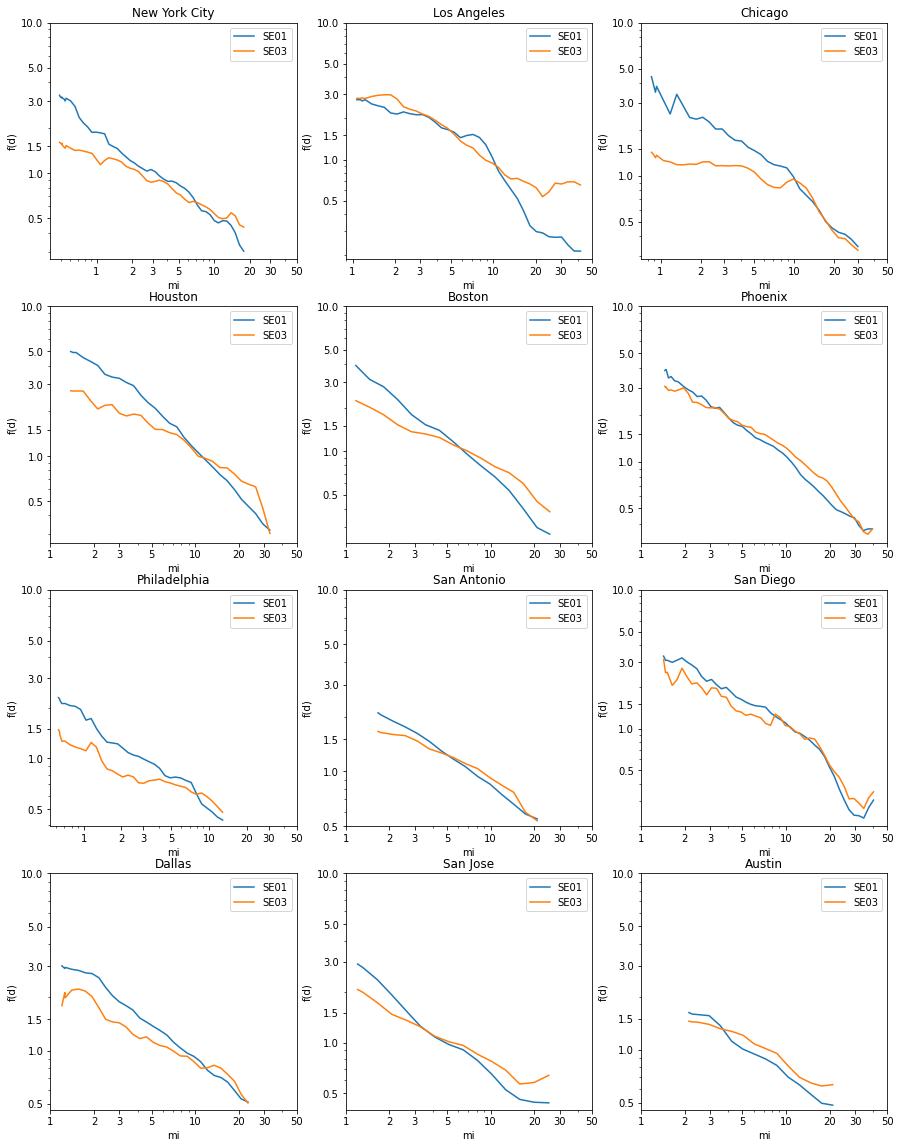

In [32]:
fig,ax = plt.subplots(4,3,figsize=(15,20))
i= 0
for city,state, counties in cities:
    if city in citieeList:
        ax[i//3,i%3].plot(Distfd1[city].keys(),Distfd1[city].values(),label='SE01')
        ax[i//3,i%3].plot(Distfd3[city].keys(),Distfd3[city].values(),label='SE03')
        ax[i//3,i%3].set_title(city)
        ax[i//3,i%3].legend()
        ax[i//3,i%3].set_yscale('log')
        ax[i//3,i%3].set_xscale('log')
        ax[i//3,i%3].set_yticks([0.5, 1, 1.5, 3, 5, 10])
        ax[i//3,i%3].set_xticks([1, 2, 3, 5, 10, 20, 30, 50])
        ax[i//3,i%3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax[i//3,i%3].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax[i//3,i%3].set_ylabel('f(d)')
        ax[i//3,i%3].set_xlabel('mi')
        i += 1

plt.savefig('img/curve.png')

## Monte Carlo simulation

In [66]:
NUM_POINTS = 20

def generate_random_points(shape):
    minx, miny, maxx, maxy = shape.bounds
    xc = (maxx - minx) * np.random.random(NUM_POINTS) + minx
    yc = (maxy - miny) * np.random.random(NUM_POINTS) + miny

    points = gpd.GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
    filtered_points = points.loc[points.within(shape)]
    points_geo = list(zip(filtered_points.y, filtered_points.x))
    return points_geo
    
def get_avg_point_to_point_distance(shape_a, shape_b):
    points_a = generate_random_points(shape_a)
    points_b = generate_random_points(shape_b)
    common_points = min(len(points_a), len(points_b), 1)
    if common_points == 0:
        return None
    
    points_a_c = points_a[0:common_points]
    points_b_c = points_b[0:common_points]
    distance = haversine_vector(points_a_c, points_b_c, Unit.KILOMETERS)
    mean_distance = statistics.mean(distance)
    return mean_distance


SAMPLES = 20000


def get_avg_distance(gdf):
    output = []
    for i in range(SAMPLES):
        sample = gdf.sample(n = 2)

        shape_a = sample.reset_index().loc[0]["geometry"]
        shape_b = sample.reset_index().loc[1]["geometry"]
        id_a = sample.index[0]
        id_b = sample.index[1]
        avg_distance = get_avg_point_to_point_distance(shape_a, shape_b)
        if avg_distance is not None:
            output.append({'from': id_a, 'to': id_b, 'p2p_avg_distance': avg_distance})
    
    pdf = pd.DataFrame(output)
    return pdf

In [67]:
output = {}
for city, state, conties in cities:
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    training_set = build_training_set(city_network, 'S000')
    nodes = city_network.nodes
    avg_distance = get_avg_distance(nodes)
    
    merged = pd.merge(training_set, avg_distance,  how='inner', left_on=['origin','destination'], right_on = ['from','to'])
    merged_filtered = merged
    merged_filtered['delta'] = np.abs(merged_filtered.distance - merged_filtered.p2p_avg_distance)
    quantiles = merged_filtered.delta.quantile([.5, .6, .7, .8, .9, 0.95, 0.99])
    output[city] = quantiles.to_dict()
    error = merged_filtered.delta.mean() 
    print(f"{city}: {error}")

New York City: 0.23318465336358488
Los Angeles: 0.5880542251098596
Chicago: 0.47264545956451637
Houston: 0.8544507944813855
Boston: 0.7216409787770274
Phoenix: 1.0696908912977126
Philadelphia: 0.35620353722320486
San Antonio: 0.9753960859438853
San Diego: 0.9532767780401463
Dallas: 0.729267064123792
San Jose: 0.7819044087441388
Austin: 1.136174461579971


In [ ]:
pd.DataFrame(output)

,New York City,Los Angeles,Chicago,Houston,Boston,Phoenix,Philadelphia,San Antonio,San Diego,Dallas,San Jose,Austin
0.50,0.176530,0.373929,0.349259,0.626014,0.483576,0.589840,0.277706,0.689228,0.563316,0.565688,0.485094,0.751230
0.60,0.220729,0.473481,0.443118,0.797668,0.639243,0.751285,0.347748,0.872422,0.722217,0.708454,0.615565,0.975461
0.70,0.277682,0.596798,0.564801,1.009724,0.837312,0.961928,0.431537,1.096358,0.909662,0.885414,0.781659,1.256536
0.80,0.351193,0.771752,0.736969,1.300103,1.133779,1.257603,0.543070,1.424256,1.229035,1.131133,1.013852,1.681846
0.90,0.485592,1.097315,1.021622,1.814740,1.670841,1.906330,0.729216,2.080797,1.932760,1.543676,1.496020,2.560253
0.95,0.640003,1.555651,1.317518,2.404259,2.250880,3.011811,0.933643,3.029391,3.037446,1.980435,2.248784,3.560927
0.99,1.091991,3.864622,2.119622,4.155098,3.541665,11.672539,1.558372,5.184831,7.811290,3.028761,5.252093,6.235240
